### Maximum Margin IRL from Trajectories

#### Reward Function Representation
The reward function is modeled as a linear combination of Gaussian basis functions:
$$
R(s) = \sum_{i=1}^{d} \alpha_i \phi_i(s)
$$
where $\phi_i(s)$ are Gaussian basis functions, and $\alpha_i$ are weights.

---

#### Basis Functions
Each Gaussian basis function is defined as:
$$
\phi_i(s) = \exp\left(-\frac{(s - \mu_i)^2}{2\sigma^2}\right)
$$
where $\mu_i$ is the mean and $\sigma$ the standard deviation.

- $\{\phi_i(s)\}_{i=1}^{d}$ span the state space.
- $\sigma$ controls overlap and smoothness.

---

#### Value Function Estimation
The value function under policy $\pi$ is:
$$
\hat{V}^{\pi}(S_0) = \mathbb{E}\left[\sum_{t=0}^{T} \beta^t R(S_t)\right]
$$
Substituting $R(s)$:
$$
\hat{V}^{\pi}(S_0) = \sum_{i=1}^{d} \alpha_i \mathbb{E}\left[\sum_{t=0}^{T} \beta^t \phi_i(S_t)\right] = \sum_{i=1}^{d} \alpha_i \hat{V}_i^{\pi}(S_0)
$$
where $\beta$ is the discount factor.

---

#### Data Requirements
- Trajectories $\{S_0, S_1, \dots, S_T\}$ under optimal policy $\pi^*$.
- Properties:
  - Diverse initial states $S_0$.
  - Sufficient length $T$.
  - Enough trajectories for robust estimation.

---

#### Linear Programming for Reward Estimation
To estimate $\alpha_i$, solve:
$$
\text{maximize} \quad \sum_{i=1}^{d} (\hat{V}^{\pi^*}_i(S_0) - \hat{V}^{\pi_{\text{rand}}}_i(S_0)) \alpha_i
$$
Subject to:
$$
|\alpha_i| \leq 1, \quad \forall i
$$

---

#### Iterative Refinement
1. Initialization: Use $\pi^*$ trajectories to estimate $\hat{V}^{\pi^*}$.
2. Policy Simulation: Generate trajectories using the current reward estimate.
3. Value Update: Recalculate $\hat{V}_i^{\pi}$ for updated policies.
4. Optimize: Solve LP to update $\alpha_i$.
5. Convergence Check: Stop if $\|\alpha^{(k+1)} - \alpha^{(k)}\| < \epsilon$.

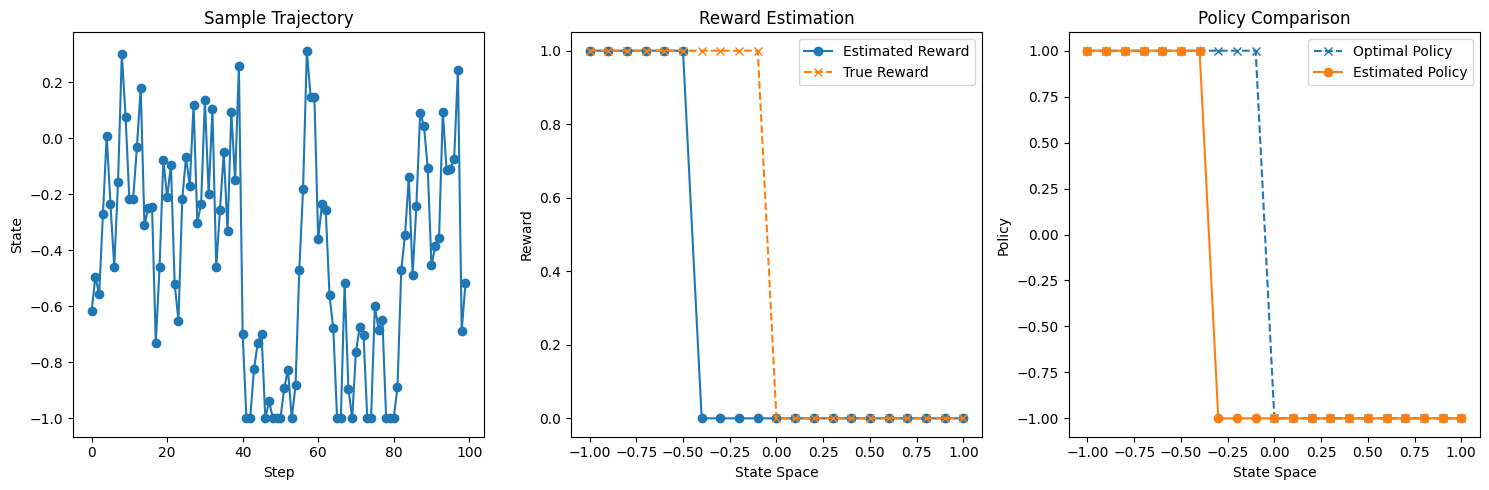

In [ ]:
import numpy as np
from numpy.random import uniform
from functools import reduce
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

############################
# Hyperparameters
############################

# Seed for reproducibility
SEED = 1234
np.random.seed(SEED)

# Simulation Parameters
N_TRAJECTORIES = 20         # Number of trajectories to simulate per policy
TRAJECTORY_LENGTH = 100     # Number of steps per trajectory

# IRL Algorithm Parameters
DISCOUNT_FACTOR = 0.9       # Discount factor for future rewards
N_BASIS_FUNCTIONS = 21      # Number of Gaussian basis functions
MAX_ITERATIONS = 20         # Maximum number of IRL iterations
CONVERGENCE_THRESHOLD = 0.1 # Threshold for alpha convergence

############################
# Helper Functions
############################

def pi_star(s):
    """Optimal policy: Stay (1) if s < 0, Switch (-1) if s >= 0."""
    return 1 if s < 0 else -1

def noise():
    """Random noise uniform in [-0.5, 0.5]."""
    return uniform(-0.5, 0.5)

def truncate_state(s):
    """Truncate state s to be within [-1, 1]."""
    return max(-1, min(1, s))

def step(s, policy):
    """Compute the next state using policy(s), adding noise, and truncating."""
    return truncate_state(policy(s) * s + noise())

def monte_carlo_sim(policy, n_trajectories=N_TRAJECTORIES, trajectory_length=TRAJECTORY_LENGTH):
    """Simulate multiple trajectories under a given policy."""
    trajectories = []
    for _ in range(n_trajectories):
        s0 = uniform(-1, 1)
        traj = [s0]
        for __ in range(trajectory_length - 1):
            s_next = step(traj[-1], policy)
            traj.append(s_next)
        trajectories.append(traj)
    return trajectories

def calc_value_function_estimate(trajectories, discount=DISCOUNT_FACTOR, n_basis=N_BASIS_FUNCTIONS):
    """
    Calculate the value function estimates for a given set of trajectories.
    - Gaussian basis functions span the state space.
    - Discounted sums of rewards are averaged over trajectories.
    """
    means = np.linspace(-1, 1, n_basis)
    sd = 2 / 22
    max_length = max(len(traj) for traj in trajectories)
    discounts = np.array([discount**t for t in range(max_length)])
    
    values = np.zeros(n_basis)
    for i, m in enumerate(means):
        traj_returns = []
        for traj in trajectories:
            phi_values = norm.pdf(traj, loc=m, scale=sd)
            effective_discounts = discounts[: len(traj)]
            traj_return = np.sum(phi_values * effective_discounts)
            traj_returns.append(traj_return)
        values[i] = np.mean(traj_returns) if traj_returns else 0.0
    return values

def reward_function(s, alpha, n_basis=N_BASIS_FUNCTIONS):
    """Compute R(s) = sum(alpha_i * phi_i(s)), where phi_i are Gaussian basis functions."""
    means = np.linspace(-1, 1, n_basis)
    sd = 2 / 22
    phi_values = norm.pdf(s, loc=means, scale=sd)
    return np.sum(alpha * phi_values)

def construct_random_policy():
    """Generate a random policy based on a random inflection point and shape."""
    shape = np.random.choice([-1, 1])
    inflection = np.random.choice(np.linspace(-1, 1, 21))
    return lambda s: -shape if s < inflection else shape

def solve_lp_for_alphas(value_pi_star, list_of_other_values):
    """Solve the LP to estimate alphas maximizing differences in value functions."""
    V_pi_star = list_of_other_values[-1]
    total_diff = np.zeros_like(V_pi_star)
    for j in range(len(list_of_other_values) - 1):
        total_diff += (V_pi_star - list_of_other_values[j])
    c = -total_diff  # Maximize by minimizing negative
    A_ub = np.eye(len(c))
    b_ub = np.ones(len(c))
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1), method='highs')
    if res.success:
        return res.x
    else:
        raise ValueError("LP did not find a feasible solution.")

def lp_irl_sample_trajectories(data, max_iter=MAX_ITERATIONS, discount=DISCOUNT_FACTOR, n_basis=N_BASIS_FUNCTIONS):
    """Run the iterative IRL process to estimate alphas and value functions."""
    value_pi_star = calc_value_function_estimate(data, discount=discount, n_basis=n_basis)
    value_functions = [value_pi_star]
    alpha = np.zeros(n_basis)
    pi_current = construct_random_policy()
    
    for i in range(max_iter):
        traj = monte_carlo_sim(pi_current)
        value_pi_current = calc_value_function_estimate(traj, discount=discount, n_basis=n_basis)
        value_functions = [value_pi_current] + value_functions
        alpha_next = solve_lp_for_alphas(value_functions[-1], value_functions)
        if i >= 4 and np.max(np.abs(alpha_next - alpha)) < CONVERGENCE_THRESHOLD:
            return alpha_next, value_functions
        alpha = alpha_next
        pi_current = lambda s, alpha=alpha: 1 if reward_function(s, alpha) > 0.5 else -1
    return alpha, value_functions

############################
# Main Execution
############################

if __name__ == "__main__":
    data = monte_carlo_sim(pi_star, n_trajectories=N_TRAJECTORIES, trajectory_length=TRAJECTORY_LENGTH)
    alpha_est, _ = lp_irl_sample_trajectories(data)
    true_reward = np.array([1]*10 + [0]*11)
    x_vals = np.linspace(-1, 1, N_BASIS_FUNCTIONS)
    
    plt.figure(figsize=(15, 5))
    
    # (1) Plot a sample trajectory
    plt.subplot(1, 3, 1)
    plt.plot(data[0], marker='o')
    plt.title("Sample Trajectory")
    plt.xlabel("Step")
    plt.ylabel("State")
    
    # (2) Plot reward estimates vs true reward
    plt.subplot(1, 3, 2)
    plt.plot(x_vals, alpha_est, label="Estimated Reward", marker='o')
    plt.plot(x_vals, true_reward, label="True Reward", linestyle='--', marker='x')
    plt.title("Reward Estimation")
    plt.xlabel("State Space")
    plt.ylabel("Reward")
    plt.legend()
    
    # (3) Plot policy comparison
    plt.subplot(1, 3, 3)
    optimal_policy = [pi_star(x) for x in x_vals]
    estimated_policy = [1 if reward_function(x, alpha_est) > 0.5 else -1 for x in x_vals]
    plt.plot(x_vals, optimal_policy, label="Optimal Policy", linestyle='--', marker='x')
    plt.plot(x_vals, estimated_policy, label="Estimated Policy", marker='o')
    plt.title("Policy Comparison")
    plt.xlabel("State Space")
    plt.ylabel("Policy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Estimation 1 complete, margin=3.4661
Estimation 2 complete, margin=3.4402
Estimation 3 complete, margin=3.4352
Estimation 4 complete, margin=3.5324
Estimation 5 complete, margin=3.4782
Estimation 6 complete, margin=3.4716
Estimation 7 complete, margin=3.4450
Estimation 8 complete, margin=3.4710
Estimation 9 complete, margin=3.4352
Estimation 10 complete, margin=3.4352
Estimation 11 complete, margin=3.4842
Estimation 12 complete, margin=3.4352
Estimation 13 complete, margin=3.4451
Estimation 14 complete, margin=3.4421
Estimation 15 complete, margin=3.5812
Estimation 16 complete, margin=3.4352
Estimation 17 complete, margin=3.4810
Estimation 18 complete, margin=3.4498
Estimation 19 complete, margin=3.4579
Estimation 20 complete, margin=3.5377


/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_64226/642413482.py:203: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_estimates[:, state_idx], shade=True, label="Estimated")
/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_64226/642413482.py:203: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_estimates[:, state_idx], shade=True, label="Estimated")
/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_64226/642413482.py:203: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_estimates[:, state_idx], shade=True, label="Estimated")
/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_64

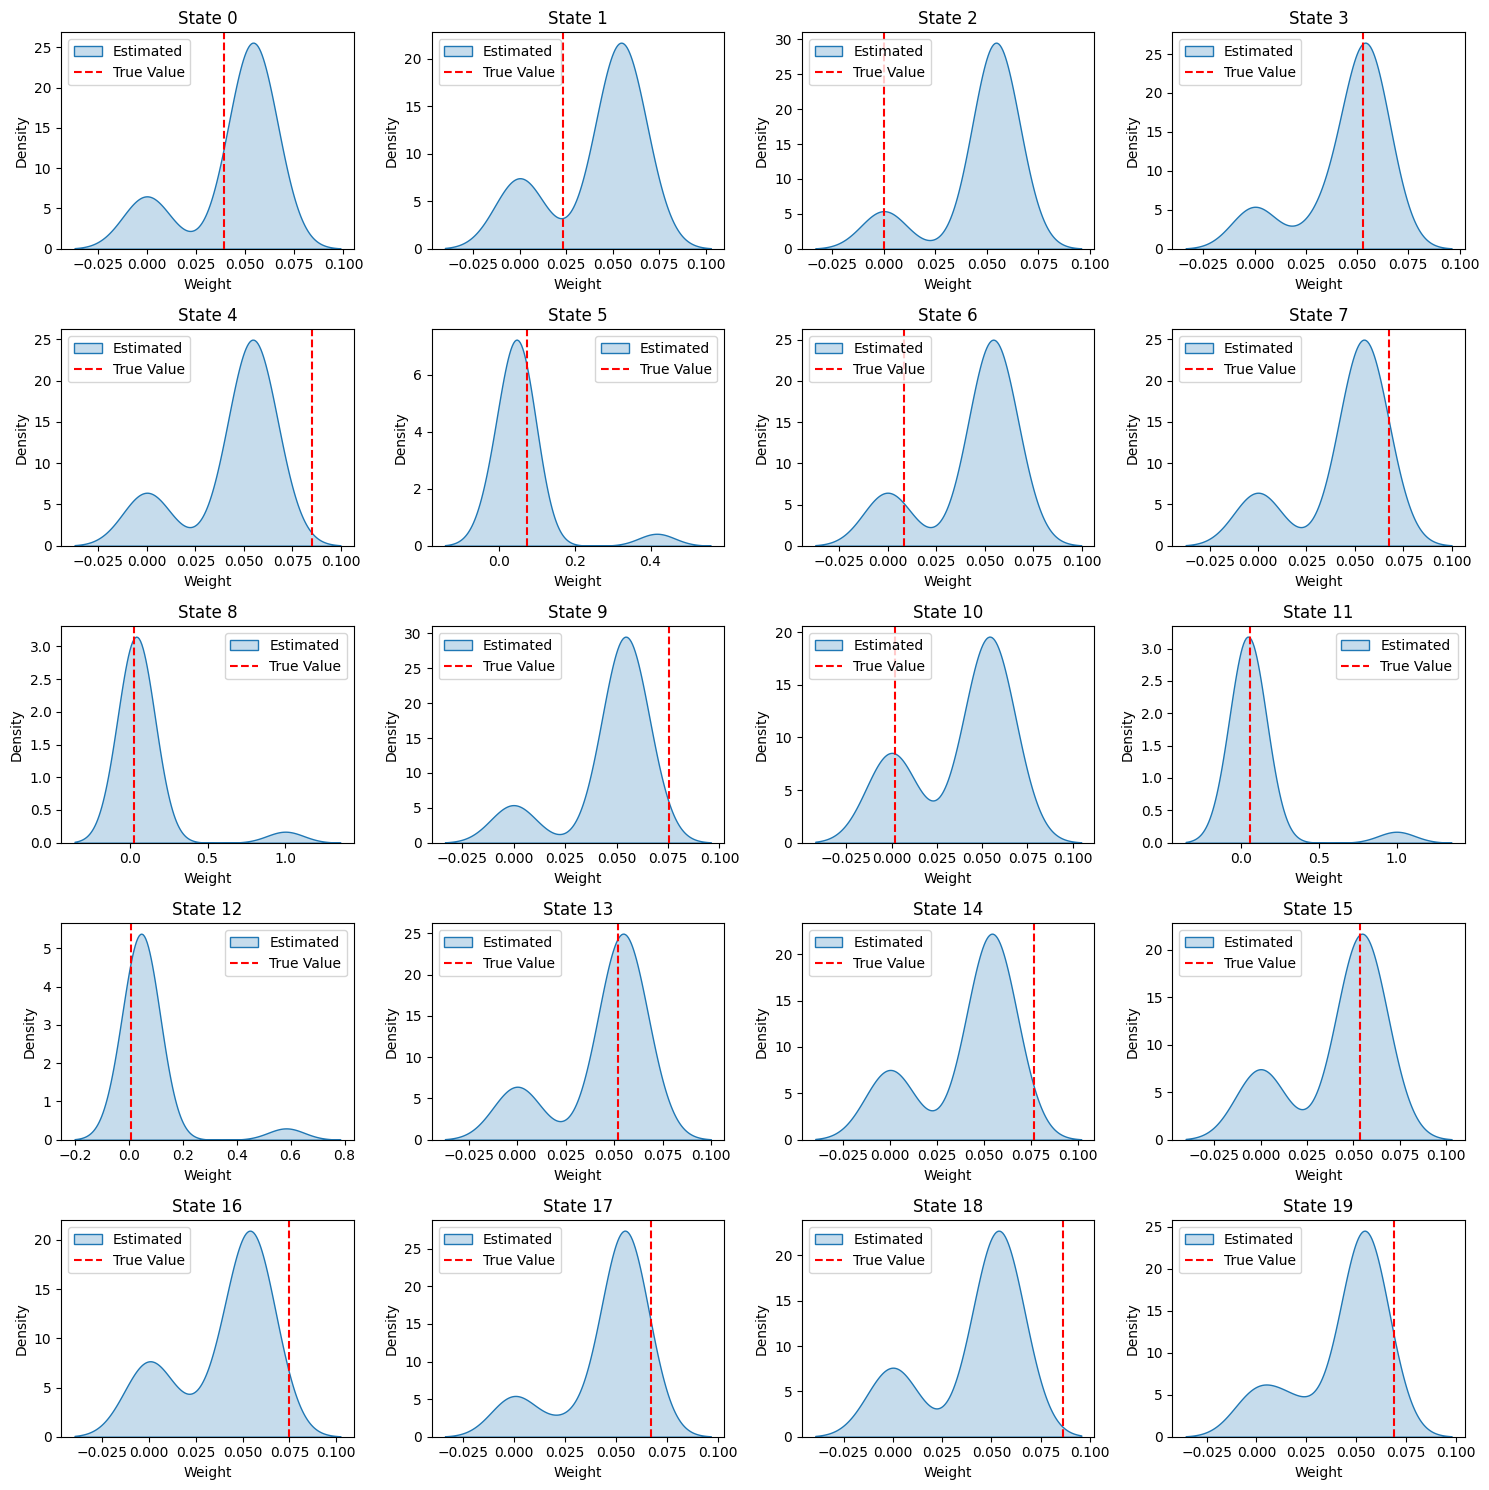

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog

# Normalization function
def normalize_weights(weights):
    weights = weights - np.min(weights)  # Shift to make all values >= 0
    sum_w = weights.sum()
    if sum_w > 0:
        weights /= sum_w  # Ensure sum is 1
    else:
        weights = np.zeros_like(weights)
    return weights

# Generate random MDP
def generate_random_mdp(num_states, num_actions, max_reward):
    R_true = np.random.uniform(0, max_reward, size=num_states)
    R_true = normalize_weights(R_true)  # Normalize true weights
    Pssa = np.zeros((num_states, num_states, num_actions))
    for s in range(num_states):
        for a in range(num_actions):
            probabilities = np.random.rand(num_states)
            probabilities /= probabilities.sum()
            Pssa[s, :, a] = probabilities
    return R_true, Pssa

# Value Iteration
def value_iteration(num_states, num_actions, reward, Pssa, discount, eps=1e-5):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)

    for _ in range(1000):  # Hard-coded iteration limit
        Q = np.zeros((num_states, num_actions))
        for a in range(num_actions):
            Q[:, a] = reward + discount * (Pssa[:, :, a] @ V)
        V_new = np.max(Q, axis=1)
        if np.max(np.abs(V_new - V)) < eps:
            break
        V = V_new

    policy = np.argmax(Q, axis=1)
    return V, policy

# Generate Expert Trajectories
def generate_trajectories(num_trajectories, Pssa, policy, num_states, max_steps=10):
    trajectories = []
    for _ in range(num_trajectories):
        state = np.random.choice(num_states)  # Random initial state
        trajectory = []
        for _ in range(max_steps):
            action = policy[state]
            trajectory.append((state, action))
            state = np.random.choice(num_states, p=Pssa[state, :, action])
        trajectories.append(trajectory)
    return trajectories

# State Features
def state_features(num_states):
    return np.eye(num_states)

# Feature Expectations
def feature_expectations(features, trajectories, discount):
    expectations = np.zeros(features.shape[1])
    for trajectory in trajectories:
        for t, (state, _) in enumerate(trajectory):
            expectations += (discount ** t) * features[state]
    expectations /= len(trajectories)
    return expectations

# Initial State Distribution
def initial_state_distribution(num_states, trajectories):
    state_counts = np.zeros(num_states)
    for trajectory in trajectories:
        state_counts[trajectory[0][0]] += 1
    return state_counts / len(trajectories)

def generate_random_policy(num_states, num_actions):
    # Random policy: each state chooses an action uniformly at random
    return np.random.randint(num_actions, size=num_states)

def simulate_policy(num_trajectories, Pssa, policy, num_states, max_steps=10):
    """
    Simulate trajectories under a given policy.
    """
    trajectories = []
    for _ in range(num_trajectories):
        state = np.random.choice(num_states)
        trajectory = []
        for __ in range(max_steps):
            a = policy[state]
            trajectory.append((state, a))
            state = np.random.choice(num_states, p=Pssa[state, :, a])
        trajectories.append(trajectory)
    return trajectories

def maxmargin_irl_with_error(num_states, num_actions, Pssa, trajectories, discount, R_true,
                             learning_rate=0.1, num_iterations=100, eps=1e-5, num_comparator_policies=5):
    """
    Implement a simplified Max-Margin IRL approach:
    1. Compute mu_D: feature expectations of expert trajectories.
    2. Generate a set of comparator policies (random).
    3. Compute their feature expectations mu_j.
    4. Solve LP to find alpha and margin that maximize margin subject to alpha * mu_D >= alpha * mu_j + margin.
    """

    features = state_features(num_states)
    mu_D = feature_expectations(features, trajectories, discount)

    # Generate comparator policies and their feature expectations
    comparator_expectations = []
    for _ in range(num_comparator_policies):
        pol = generate_random_policy(num_states, num_actions)
        comp_traj = simulate_policy(200, Pssa, pol, num_states, max_steps=10)  # simulate enough to get stable estimate
        mu_j = feature_expectations(features, comp_traj, discount)
        comparator_expectations.append(mu_j)
    comparator_expectations = np.array(comparator_expectations)

    # Solve LP:
    # We want to maximize margin m
    # s.t. alpha * mu_D >= alpha * mu_j + m for all j
    # => alpha * (mu_D - mu_j) - m >= 0
    # Let x = [alpha_1,...,alpha_n,m]
    # For each j: (mu_D - mu_j)*alpha - m >= 0
    # => -(mu_D - mu_j)*alpha + m <= 0

    num_states = features.shape[1]
    # Objective: maximize m => minimize -m
    c = np.zeros(num_states + 1)
    c[-1] = -1.0  # minimize -margin

    A_ub = []
    b_ub = []
    for mu_j in comparator_expectations:
        diff = mu_D - mu_j
        row = np.zeros(num_states + 1)
        row[:num_states] = -diff
        row[-1] = 1.0
        A_ub.append(row)
        b_ub.append(0.0)

    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)
    # Bounds: 0 <= alpha_s <= 1
    # margin >= 0
    bounds = [(0,1)]*num_states + [(0,None)]

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    if not res.success:
        raise ValueError("LP did not find a feasible solution.")

    x = res.x
    alpha = x[:num_states]
    margin_val = x[-1]

    reward = normalize_weights(alpha)
    error = R_true - reward
    return reward, error, margin_val

# Main Function
def main_with_bias_analysis():
    config = {
        "num_states": 20,
        "num_actions": 20,
        "discount_factor": 0.9,
        "max_reward": 1.0,
        "num_trajectories": 5000,
        "trajectory_length": 50,
        "learning_rate": 0.1,
        "num_iterations": 5000,
        "eps": 1e-5,
        "num_runs": 20,
        "seed": 42,
    }

    np.random.seed(config["seed"])
    all_estimates = []

    for run in range(config["num_runs"]):
        R_true, Pssa = generate_random_mdp(config["num_states"], config["num_actions"], config["max_reward"])
        V_opt, policy_opt = value_iteration(config["num_states"], config["num_actions"], R_true, Pssa, config["discount_factor"])
        trajectories = generate_trajectories(config["num_trajectories"], Pssa, policy_opt, config["num_states"], max_steps=config["trajectory_length"])
        
        # Use max-margin IRL instead of maxent
        R_est, error, margin_val = maxmargin_irl_with_error(
            config["num_states"], config["num_actions"], Pssa, trajectories, config["discount_factor"],
            R_true, learning_rate=config["learning_rate"], num_iterations=config["num_iterations"], eps=config["eps"]
        )
        all_estimates.append(R_est)
        print(f"Estimation {run + 1} complete, margin={margin_val:.4f}")

    all_estimates = np.array(all_estimates)

    # Plotting KDEs for each state
    num_states = config["num_states"]
    num_cols = 4
    num_rows = (num_states + num_cols - 1) // num_cols

    plt.figure(figsize=(15, num_rows * 3))
    # Since R_true changes each run, just take the last R_true for plotting
    for state_idx in range(num_states):
        plt.subplot(num_rows, num_cols, state_idx + 1)
        sns.kdeplot(all_estimates[:, state_idx], shade=True, label="Estimated")
        plt.axvline(R_true[state_idx], color='red', linestyle='--', label="True Value")
        plt.title(f"State {state_idx}")
        plt.xlabel("Weight")
        plt.ylabel("Density")
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main_with_bias_analysis()
